# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
%pip install missingno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

# Pandas configuration
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

Note: you may need to restart the kernel to use updated packages.


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [5]:
# Get summarized information about azdias dataframe
azdias.describe().T

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [6]:
# Show azdias dataframe
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
# Get summarized information about feat_info dataframe
feat_info.describe().T

,count,unique,top,freq
attribute,85,85,AGER_TYP,1
information_level,85,9,person,43
type,85,5,ordinal,49
missing_or_unknown,85,9,[-1],26


In [8]:
# Show feat_info dataframe
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Observation results

**Azdias**
- 85 columns and 891.221 rows 
- 81 numerical columns and 4 object columns
- column *KK_KUNDENTYP* contains high number of null values, most of the columns have more than 750.000 non-null values

**Feature_Info**
- contains additional information about the features in the Azdias dataframe
- some values in the Azdias dataframe represent missing or unknown data, so the number of non-null values in Azdias isn't very informative

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

First we will have a look on the values in the colummn `missing_or_unknown`. It looks like they can be all interpreted as a JSON list with the exception of the values X and XX which have to be put into quotes first.

Then we can iterate over the columns in `azdias`, finding the corresponding list of values that should be replaced with `nan` and replace them.

In [9]:
# Check which values occur in 'missing_or_unknown'
feat_info["missing_or_unknown"].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[-1,X]       1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

The values of the column *missing_or_unknown* contains a list of values that represent values which should be replaced with NaN because the actual data is either missing or unknown.

If `X` and `XX` are replaced with `'X'` and `'XX'` this list, which is a string in the dataframe, can be parsed with the JSON library.

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

def replace_missing_values_with_nan(df, df_missing_encoding):
    """
    Replace all values that represent missing or unknown values with NaN
    :param df:                  Dataframe that coontains the data
    :param df_missing_encoding: Dataframe that contains the values that represent missing or unknown data
    """
    # Replace missing values with NaN
    for i, row in df_missing_encoding.iterrows():
        # Get column name
        colname = row["attribute"]
        # Get encoding for missing values. Use json library to parse the list of values
        try:
            # replace X and XX with "X" and "XX"
            jsonstr = row["missing_or_unknown"].replace("XX]", '"XX"]').replace("X]", '"X"]')
            # Parse the list with the json library
            missing_values = json.loads(jsonstr)
        except:
            print("Error", colname, jsonstr)
        # Replace values that represent missing or unknown data with NaN
        for value in missing_values:
            df[colname] = df[colname].replace(value, np.nan)
    return df
            
azdias_tf = replace_missing_values_with_nan(azdias, feat_info[["attribute", "missing_or_unknown"]])

In [11]:
# Check how many null values are in each column
azdias_tf.isna().sum().sort_values(axis=0, ascending=False, inplace=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_ANTG1               116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
VERS_TYP                 111196
HEALTH_TYP               111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

If we count the number of missing values per column again we see that there are now more columns that have less than 750.000 valid values.

There are six columns that have more than 300.000 missing values. Next we will plot the distribution of missing values per column.

In [12]:
# Fill null values with NaN
azdias_tf.fillna(float('nan'))

# Display the transformed data frame
azdias_tf.head(n=10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,NaN,2.0,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,4,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,NaN,1.0,4,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,5,1964.0,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,NaN,1.0,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,6,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,NaN,2.0,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,1,1975.0,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,NaN,2.0,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,NaN,2.0,6.

In the dataframe *azdias_tf* values that represent missing or unknown data are replaced with NaN

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Count missing / NaN values of each column and sort columns by number of missing values
df_nan = azdias_tf.isnull().sum().sort_values(axis=0, ascending=False, inplace=False)

The dataframe *df_nan* holds the number of missing values per column.

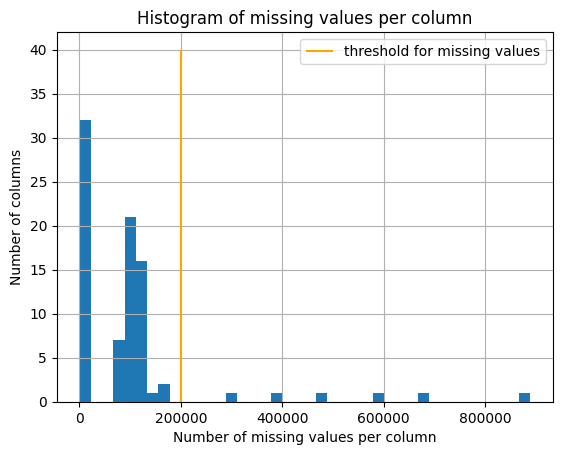

In [14]:
# Plot histogramm for missing values per column
threshold_cols = 200000

hist = df_nan.hist(bins=40)
hist.vlines(threshold_cols, ymin=0, ymax=40, color="orange", label="threshold for missing values")
hist.set_title("Histogram of missing values per column")
hist.set_xlabel("Number of missing values per column")
hist.set_ylabel("Number of columns")
hist.legend()

This histogram shows the distribution of missing records per column. All columns right of the orange line are regarded as outliers. 

Outliers have more than (200000 / 891221 > 20%) missig values. So each column that has more than 20% missing records is an outlier.

The next plots show the proportion of missing values per column.

In [15]:
# Standard deviation of number of missing values per column
df_nan_std = df_nan.std()
df_nan_std

146604.20331712818

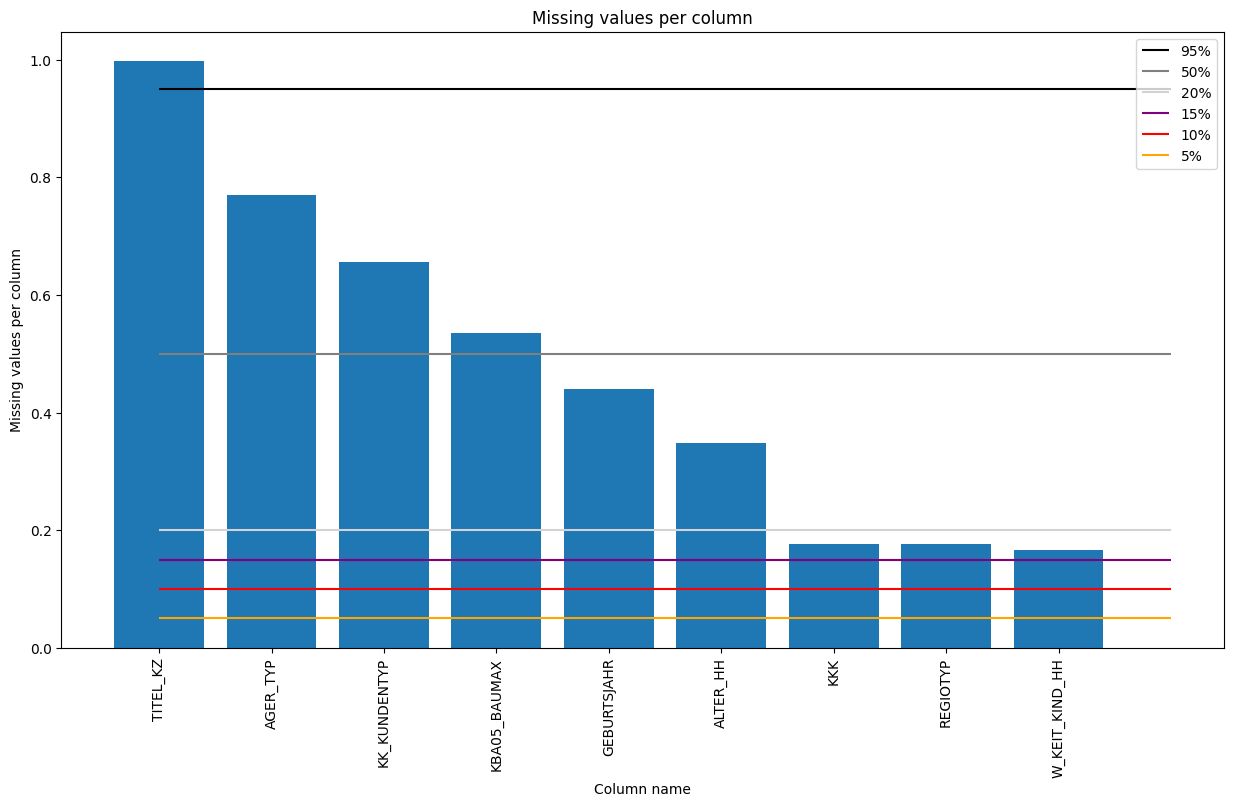

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Count missing / NaN values of each column and sort columns by number of missing values
df_nan = azdias_tf.isnull().sum().sort_values(axis=0, ascending=False, inplace=False)

# Plot bar chart that shows how many missing values are in each column
def plot_df_nan_bar_chart(times_std_min = 1, times_std_max = 5):
    fig, ax = plt.subplots(figsize=(15,8))
    plt.xticks(rotation='vertical')
    ax.set_title("Missing values per column")
    ax.set_xlabel("Column name")
    ax.set_ylabel("Missing values per column")
    # data frame query
    query = (df_nan >= (df_nan_std * times_std_min)) & (df_nan < (df_nan_std * times_std_max))
    # X and Y values
    X = df_nan.index[query]
    Y = df_nan[query] / azdias.shape[0]
    # Get maximum of missing records
    y_max = Y.max()
    ax.bar(X, Y)
    # Plot lines for one and two sigma values
    if (y_max > 0.15):
        ax.hlines(0.95, xmin=0, xmax=X.shape[0], color="black", label="95%")
        ax.hlines(0.5, xmin=0, xmax=X.shape[0], color="grey", label="50%")
        ax.hlines(0.2, xmin=0, xmax=X.shape[0], color="lightgrey", label="20%")
        ax.hlines(0.15, xmin=0, xmax=X.shape[0], color="purple", label="15%")
    ax.hlines(0.1, xmin=0, xmax=X.shape[0], color="red", label="10%")
    ax.hlines(0.05, xmin=0, xmax=X.shape[0], color="orange", label="5%")
    ax.legend()
    
plot_df_nan_bar_chart(times_std_min=1, times_std_max=10)

This histogram shows the distribution of missing records per column. All columns right of the orange line are regarded as outliers. 

Outliers have more than (200000 / 891221 > 20%) missig values. So each column that has more than 20% missing records is an outlier.

In [17]:
# Standard deviation of number of missing values per column
df_nan_std = df_nan.std()
df_nan_std

146604.20331712818

##### More than 95% of the records are missing in the following columns:

- TITEL_KZ (Academic title flag)
- AGER_TYP (Best-ager typology)
- KK_KUNDENTYP (Consumer pattern over past 12 months)
- KBA05_BAUMAX (Most common building type within the microcell)
- GEBURTSJAHR (Year of birth)
- ALTER_HH (Birthdate of head of household)

We can drop these columns because there is only few information in these columns.

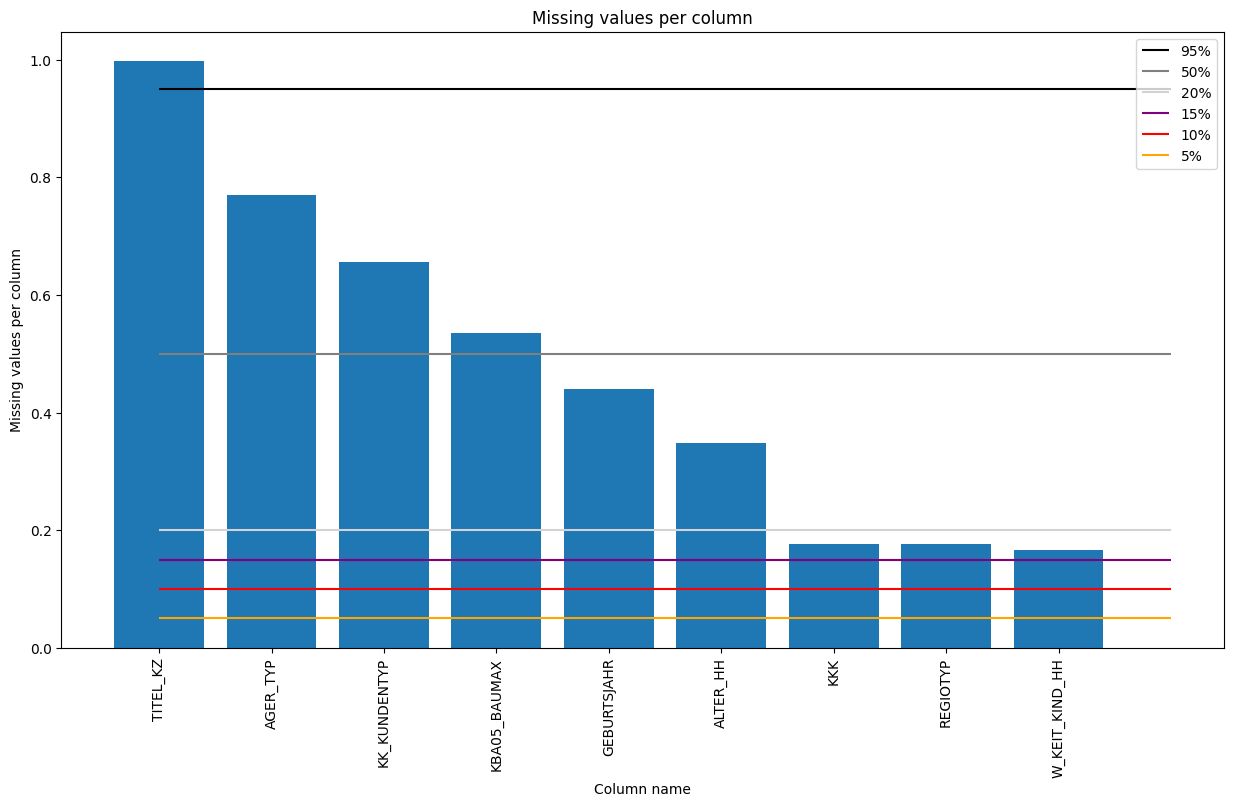

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Count missing / NaN values of each column and sort columns by number of missing values
df_nan = azdias_tf.isnull().sum().sort_values(axis=0, ascending=False, inplace=False)

# Plot bar chart that shows how many missing values are in each column
def plot_df_nan_bar_chart(times_std_min = 1, times_std_max = 5):
    fig, ax = plt.subplots(figsize=(15,8))
    plt.xticks(rotation='vertical')
    ax.set_title("Missing values per column")
    ax.set_xlabel("Column name")
    ax.set_ylabel("Missing values per column")
    # data frame query
    query = (df_nan >= (df_nan_std * times_std_min)) & (df_nan < (df_nan_std * times_std_max))
    # X and Y values
    X = df_nan.index[query]
    Y = df_nan[query] / azdias.shape[0]
    # Get maximum of missing records
    y_max = Y.max()
    ax.bar(X, Y)
    # Plot lines for one and two sigma values
    if (y_max > 0.15):
        ax.hlines(0.95, xmin=0, xmax=X.shape[0], color="black", label="95%")
        ax.hlines(0.5, xmin=0, xmax=X.shape[0], color="grey", label="50%")
        ax.hlines(0.2, xmin=0, xmax=X.shape[0], color="lightgrey", label="20%")
        ax.hlines(0.15, xmin=0, xmax=X.shape[0], color="purple", label="15%")
    ax.hlines(0.1, xmin=0, xmax=X.shape[0], color="red", label="10%")
    ax.hlines(0.05, xmin=0, xmax=X.shape[0], color="orange", label="5%")
    ax.legend()
    
plot_df_nan_bar_chart(times_std_min=1, times_std_max=10)

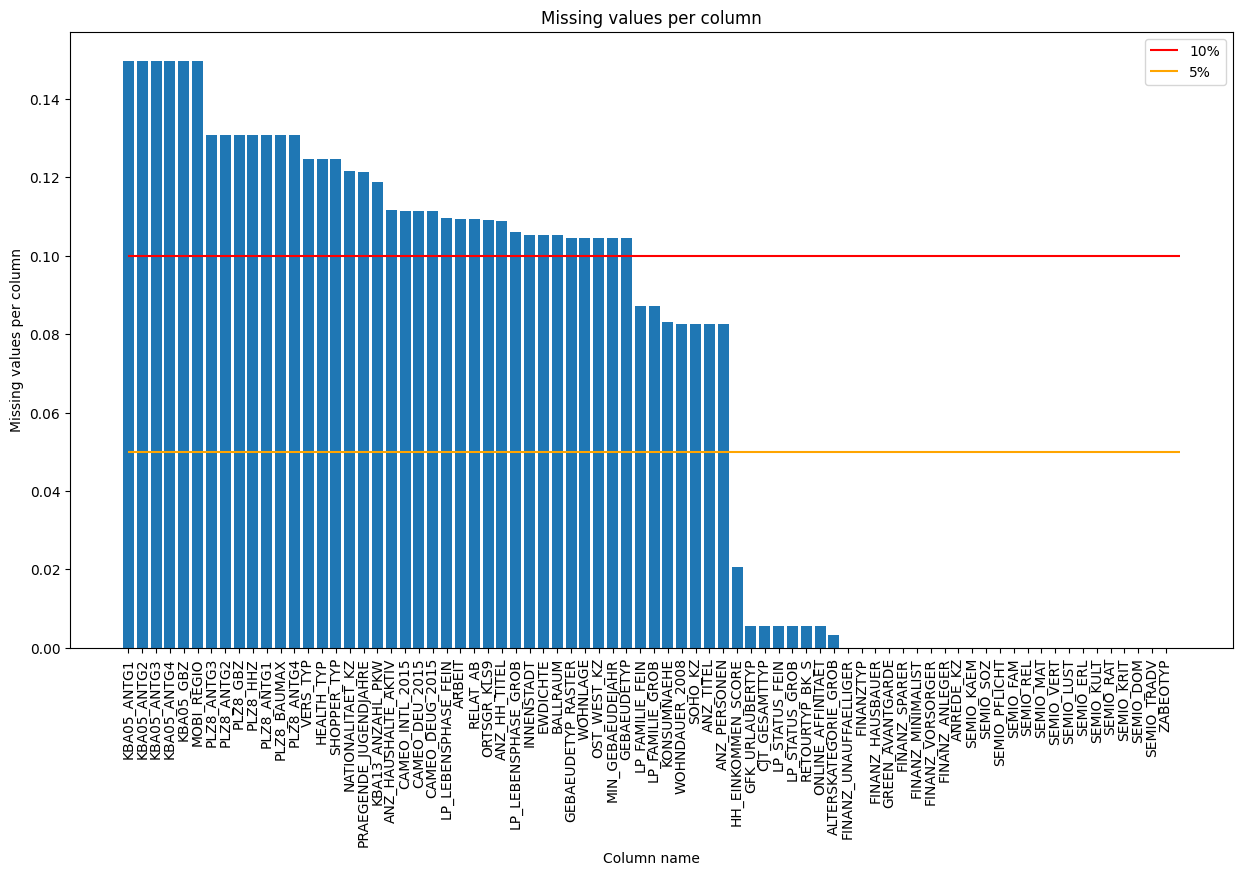

In [19]:
plot_df_nan_bar_chart(times_std_min=0, times_std_max=1)

In [20]:
# Investigate patterns in the amount of missing data in each column.
more_than_200k_percent_missing_cols = df_nan[df_nan > 200000].index.to_list()
more_than_200k_percent_missing_cols

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

##### More than 95% of the records are missing in the following columns:

- TITEL_KZ (Academic title flag)
- AGER_TYP (Best-ager typology)
- KK_KUNDENTYP (Consumer pattern over past 12 months)
- KBA05_BAUMAX (Most common building type within the microcell)
- GEBURTSJAHR (Year of birth)
- ALTER_HH (Birthdate of head of household)

We can drop these columns because there is only few information in these columns.

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_tf = azdias_tf \
    .drop(more_than_200k_percent_missing_cols, axis=1)

In [22]:
# Show new dataframe
azdias_tf

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,12.0,0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,3.0,0.0,1.0,4,1.0,0.0,4.0,3.0,4.0,15.0,0.0,8.0,3.0,1992.0,W,3.0,7,7A,41,2.0,1.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,1.0,0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,NaN,10.0,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,NaN,0.0,NaN,6,1.0,0.0,6.0,6.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,1.0,1.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,10.0,0,1.0,NaN,NaN,NaN,NaN,4.0,2.0,1.0,14.0,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,2.0,0.0,1.0,4,0.0,0.0,5.0,NaN,5.0,3.0,0.0,8.0,6.0,1992.0,W,7.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,9.0,0,1.0,29.0,9.0,9.0,5.0,2.0,1.0,1.0,14.0,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0.0,0.0,2.0,5,1.0,0.0,6.0,1.0,9.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

First we build a hsitogram that shows us how the number of missing values is distributed among the columns of the data set. We can see that there are two extreme outliers where nearly 100% of the values are missing. 

Most of the columns have less than 150.000 missing values, so we define this as our limit when a column is regarded as an outlier.

Next we build two bar charts that shows us how many values are missing for each column of the data set. The first bar charts shows all columns that have more than one standard deviation of missing values. The second bar chart shows all columns where the number of missing values is at maximum one standard deviation of the number of missing values per column.

The columns that are dropped contain information about the age and the consumer pattern of the customer.

After this step there will be 79 columns left for investigation.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

The dataframe *df_nan_rows* contains the distribution of the numbers of missing values per row.

In [23]:
# How much data is missing in each row of the dataset?
df_nan_rows = azdias_tf.isna().sum(axis=1)
df_nan_rows

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

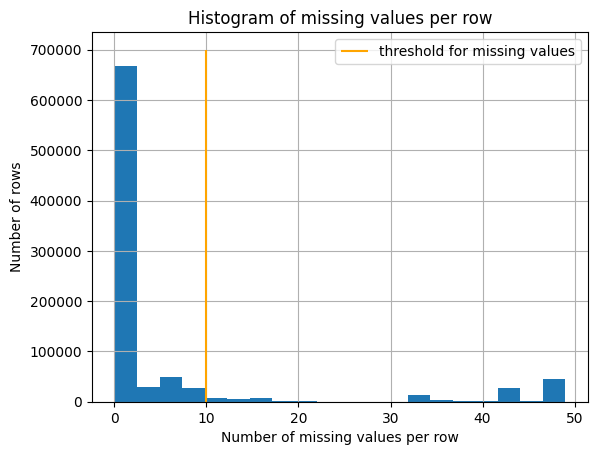

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Set the thershold for number of missing row values
threshold_missing_values = 10

# Plot histogramm for missing values per row
hist = df_nan_rows.hist(bins=20)
hist.vlines(threshold_missing_values, ymin=0, ymax=700000, color="orange", label="threshold for missing values")
hist.set_title("Histogram of missing values per row")
hist.set_xlabel("Number of missing values per row")
hist.set_ylabel("Number of rows")
hist.legend()

Find all rows that have less or equal missing values per row then the theshold value.

In [25]:
azdias_tf_few_rows_missing = azdias_tf[azdias_tf.isnull().sum(axis=1) <= threshold_missing_values]
azdias_tf_few_rows_missing

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,12.0,0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,3.0,0.0,1.0,4,1.0,0.0,4.0,3.0,4.0,15.0,0.0,8.0,3.0,1992.0,W,3.0,7,7A,41,2.0,1.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,1.0,0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,NaN,10.0,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,NaN,0.0,NaN,6,1.0,0.0,6.0,6.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,1.0,1.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,10.0,0,1.0,NaN,NaN,NaN,NaN,4.0,2.0,1.0,14.0,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,2.0,0.0,1.0,4,0.0,0.0,5.0,NaN,5.0,3.0,0.0,8.0,6.0,1992.0,W,7.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,9.0,0,1.0,29.0,9.0,9.0,5.0,2.0,1.0,1.0,14.0,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0.0,0.0,2.0,5,1.0,0.0,6.0,1.0,9.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


Calculate the percentage of rows that have more missing values than the threshold value

Find all rows that have more missing values than the theshold value

In [26]:
azdias_tf_many_rows_missing = azdias_tf[azdias_tf.isnull().sum(axis=1) > threshold_missing_values]
azdias_tf_many_rows_missing

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891173,4.0,1,1.0,4,1,5,1,2,2,5,2.0,0,1.0,16.0,4.0,2.0,2.0,3.0,2.0,1.0,1.0,4.0,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,2.0,0.0,4.0,6.0,2.0,5.0,0.0,1.0,2.0,2014.0,W,2.0,4,4C,24,NaN,NaN,NaN,NaN,NaN,6.0,5.0,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891175,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891185,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891187,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
azdias_tf_many_rows_missing.shape[0] / azdias.shape[0]

0.12462453196233034

C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

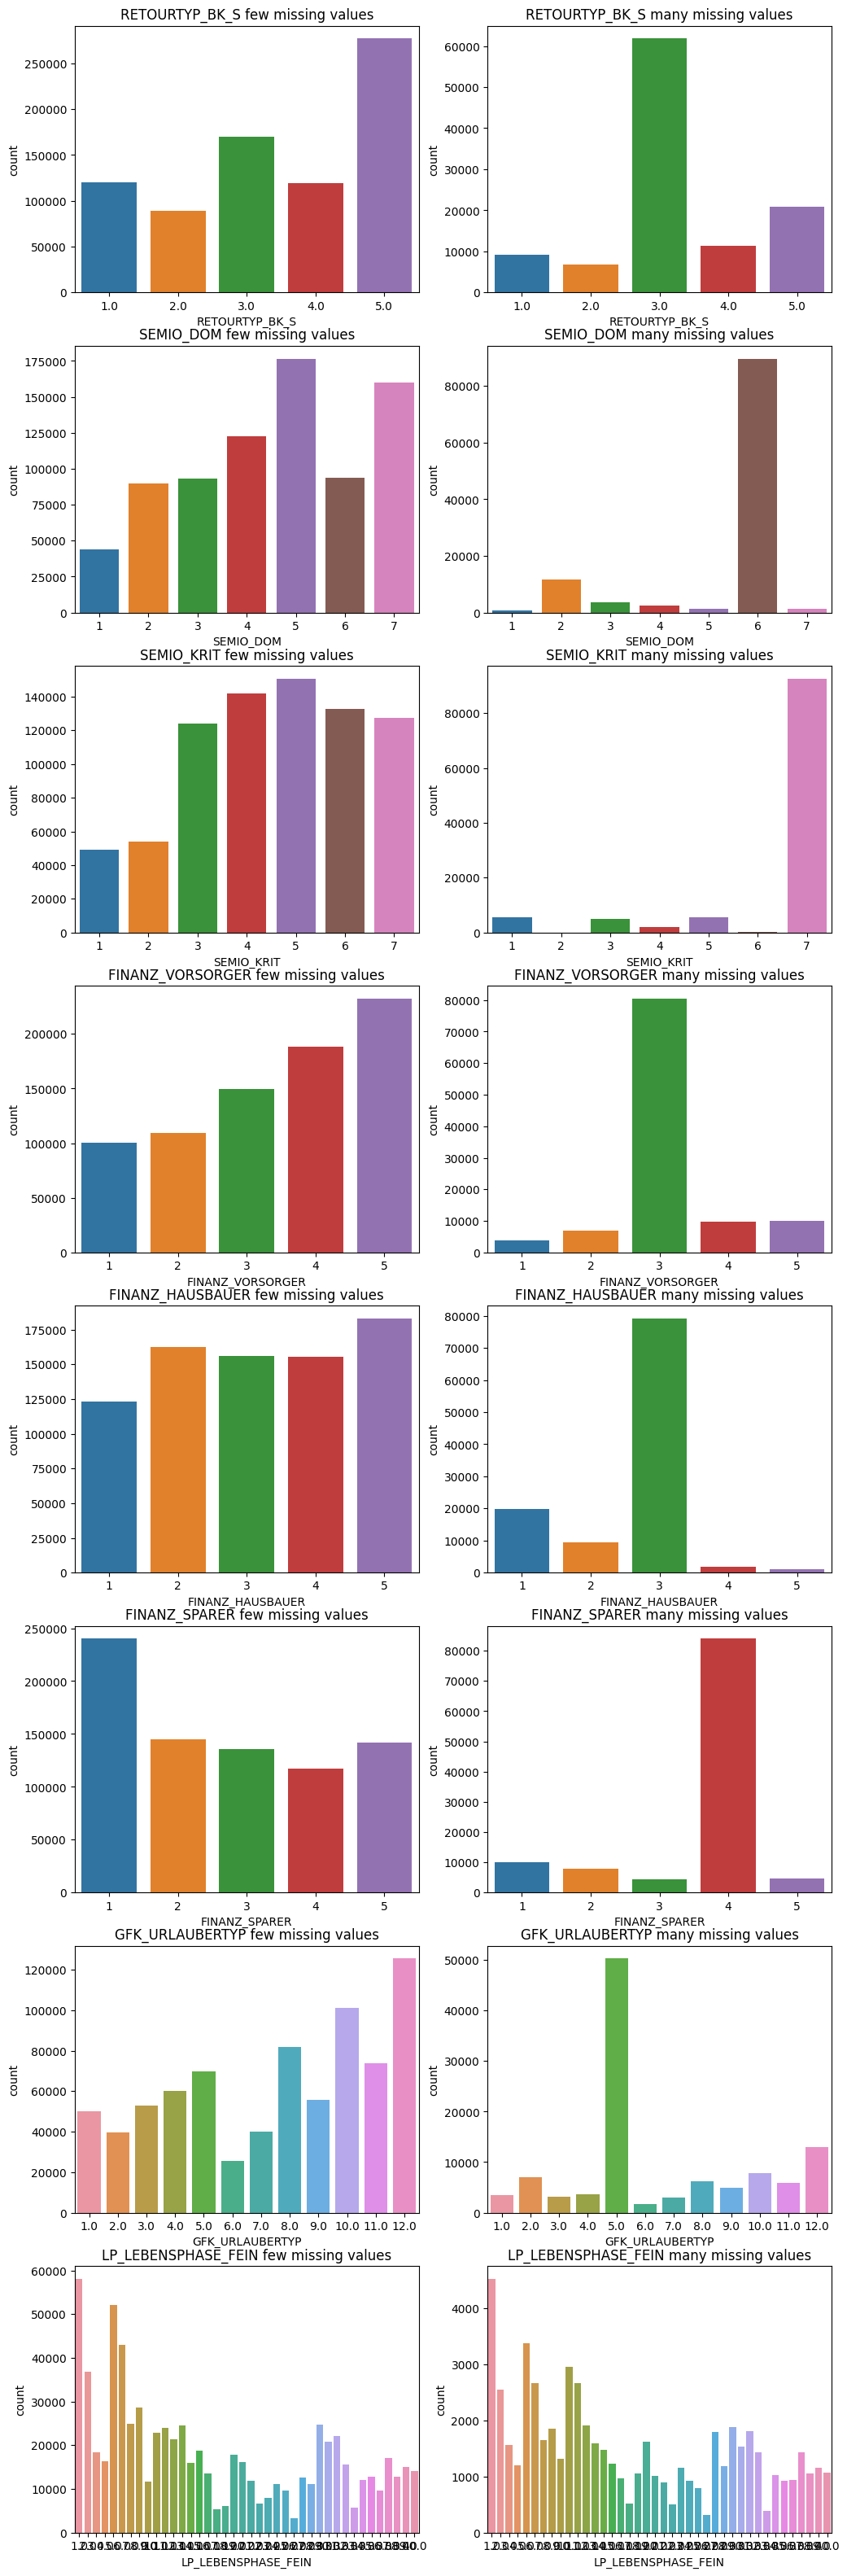

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

cols = ["RETOURTYP_BK_S", "SEMIO_DOM", "SEMIO_KRIT", "FINANZ_VORSORGER", "FINANZ_HAUSBAUER", "FINANZ_SPARER", "GFK_URLAUBERTYP", "LP_LEBENSPHASE_FEIN"]
fig, ax = plt.subplots(len(cols), 2, figsize=(12, 5*len(cols)))

for i, colname in enumerate(cols):
    #ax[i][0].hist(azdias_tf_few_rows_missing[colname])
    sns.countplot(azdias_tf_few_rows_missing[colname], ax=ax[i][0])
    ax[i][0].set_title("%s few missing values" % colname)
    #ax[i][1].hist(azdias_tf_many_rows_missing[colname])
    sns.countplot(azdias_tf_many_rows_missing[colname], ax=ax[i][1])
    ax[i][1].set_title("%s many missing values" % colname)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

First we plot a histogram for the number of missing values per row. We can see that most of the rows have less than 10 missing values. So we define 10 as our threshold for missing rows.

Next we split up the dataset into to subsets based on the number of missing values per row. The first subset contains rows where less than or exactly 10 values per row are missing. The second subset contains the rows with more than 10 values missing per row. We can see that around 12% of all rows are missing more than 10 values.

Now we plot the distribution of the values of a single row for the first and second subset. First we see that the distribution of values in the second subset differs from the second subset. We can see that in rows with many missing values the value of the colums seems to be set to a default value. Especially for financial columns it seems that missing values were set to the average value. The SEMIO-columns seem to use "low afinity" as the default value if there could no value be determined. This would also explain why there is not one missing value for these columns. 

Because these rows seem to be filled with default values we could also treat them as they contain missing values. For this reason we will drop these rows. So after this step around 100.000 rows will be dropped from the record and aroudn 800.000 rows will be left for investigation.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

##### Basic Idea

The basic idea is to add new colums to the feat_info dataframe that contain more information about the features of the azdias record. Later we can save the updated feat_info dataframe as a CSV file.

In [29]:
# How many features are there of each data type?

# Add new column named 'feature_count' that contains information how many different features there are in the column
# and colums 'feature_values' that lists distinct values of this feature
# and column 'dtype' that contains the data type of the column
feat_info["value_count"] = 0
feat_info["values"] = ""
feat_info["dtype"] = ""

# Iterate over column names
for colname in azdias_tf_few_rows_missing.columns:
    # Get index
    i = feat_info[feat_info["attribute"] == colname].index[0]
    # Count distinct values of feature
    groups = azdias_tf_few_rows_missing.groupby(colname)[colname].count()
    n_groups = len(groups)
    # Update feature dataframe
    feat_info.at[i, "dtype"] = str(azdias_tf_few_rows_missing[colname].dtype)
    feat_info.at[i, "value_count"] = n_groups
    feat_info.at[i, "values"] = json.dumps(list(groups.to_dict().keys()))
    
feat_info

,attribute,information_level,type,missing_or_unknown,value_count,values,dtype
0,AGER_TYP,person,categorical,"[-1,0]",0,,
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",4,"[1.0, 2.0, 3.0, 4.0]",float64
2,ANREDE_KZ,person,categorical,"[-1,0]",2,"[1, 2]",int64
3,CJT_GESAMTTYP,person,categorical,[0],6,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",float64
4,FINANZ_MINIMALIST,person,ordinal,[-1],5,"[1, 2, 3, 4, 5]",int64
5,FINANZ_SPARER,person,ordinal,[-1],5,"[1, 2, 3, 4, 5]",int64
6,FINANZ_VORSORGER,person,ordinal,[-1],5,"[1, 2, 3, 4, 5]",int64
7,FINANZ_ANLEGER,person,ordinal,[-1],5,"[1, 2, 3, 4, 5]",int64
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],5,"[1, 2, 3, 4, 5]",int64
9,FINANZ_HAUSBAUER,person,ordinal,[-1],5,"[1, 2, 3, 4, 5]",int64


Now the `feat_info` dataframe contains additional information about the number of values in a column (`value_count`), the distinct values themself (`values`) and the data type of the numpy column (`dtype`).

#### Finding binary categorical columns

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get all binary categorical features
query_binary = (feat_info["type"] == "categorical") & (feat_info["value_count"] == 2)
feat_binary = feat_info[query_binary]
feat_binary

,attribute,information_level,type,missing_or_unknown,value_count,values,dtype
2,ANREDE_KZ,person,categorical,"[-1,0]",2,"[1, 2]",int64
13,GREEN_AVANTGARDE,person,categorical,[],2,"[0, 1]",int64
39,SOHO_KZ,person,categorical,[-1],2,"[0.0, 1.0]",float64
41,VERS_TYP,person,categorical,[-1],2,"[1.0, 2.0]",float64
55,OST_WEST_KZ,building,categorical,[-1],2,"[""O"", ""W""]",object


#### Binary categorical columns with non-numeric values

"OST_WEST_KZ" is the binary feature that takes on non-numeric values

The features "ANREDE_KZ", "GREEN_AVANTGARDE" and "SOHO_KZ" don't need to be reencoded, because they are already numeric.

#### Multi-level categorical columns

In [31]:
# Get all multi-level categorical features
query_multi_level = (feat_info["type"] == "categorical") & (feat_info["value_count"] > 2)
feat_multi_level = feat_info[query_multi_level]
feat_multi_level

,attribute,information_level,type,missing_or_unknown,value_count,values,dtype
3,CJT_GESAMTTYP,person,categorical,[0],6,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",float64
10,FINANZTYP,person,categorical,[-1],6,"[1, 2, 3, 4, 5, 6]",int64
12,GFK_URLAUBERTYP,person,categorical,[],12,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",float64
17,LP_FAMILIE_FEIN,person,categorical,[0],11,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",float64
18,LP_FAMILIE_GROB,person,categorical,[0],5,"[1.0, 2.0, 3.0, 4.0, 5.0]",float64
19,LP_STATUS_FEIN,person,categorical,[0],10,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",float64
20,LP_STATUS_GROB,person,categorical,[0],5,"[1.0, 2.0, 3.0, 4.0, 5.0]",float64
21,NATIONALITAET_KZ,person,categorical,"[-1,0]",3,"[1.0, 2.0, 3.0]",float64
38,SHOPPER_TYP,person,categorical,[-1],4,"[0.0, 1.0, 2.0, 3.0]",float64
42,ZABEOTYP,person,categorical,"[-1,9]",6,"[1, 2, 3, 4, 5, 6]",int64


There are 13 categorical feature that have more than two distinct values, but only two feature have non-numerical values. These are the features that need one-hot encoding.

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Get attribute names for binary features that need reencoding
binary_features = feat_binary[feat_binary["attribute"] == "OST_WEST_KZ"]["attribute"]

# Get attribute names for multi-level features that need reencoding
multi_level_features = feat_multi_level["attribute"]

# Combine both series, the result is a series of feature names that will be encoded with one hot encoding
ohe_cols = multi_level_features.combine_first(binary_features)
ohe_cols

3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

Now we perform one-hot encoding on all these columns.

In [33]:
# Reencode the dataset with dummy variables
azdias_dummies = pd.get_dummies(azdias_tf_few_rows_missing, prefix=ohe_cols.to_list(), columns=ohe_cols)
azdias_dummies.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

First we added new features to the feat_info dataframe. We added information about the data type of the azdias features, their number of distinct values and a list of distinct features. This is done to help us decide which columns need to be reencoded with dummy variables.

Next we build two dataframes. The first one containes all features that are categorical and binary. We can see that only the feature "OST_WEST_KZ" needs to be reencoded with dummy variables because its values are non-numerical.

The second dataframe contains all the features that are categorical and have multi-level values that are not ordinal. All of these features need to reencoded with dummy variables because of their non-ordinal nature.

Finally we apply one-hot-encoding to all columns that are multi-level categoricals. We merge this one-hot encoded data frame with the original data frame. This results in a data frame that has 195 features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# First let's have a look which columns have mixed values
feat_info[feat_info["type"] == "mixed"]

,attribute,information_level,type,missing_or_unknown,value_count,values,dtype
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],40,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",float64
16,LP_LEBENSPHASE_GROB,person,mixed,[0],12,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",float64
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]",15,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",float64
56,WOHNLAGE,building,mixed,[-1],8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0]",float64
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]",21,"[""12"", ""13"", ""14"", ""15"", ""22"", ""23"", ""24"", ""25...",object
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",0,,
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]",5,"[1.0, 2.0, 3.0, 4.0, 5.0]",float64


#### Add new column 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'

Add a new column named `PRAEGENDE_JUGENDJAHRE_MOVEMENT` that contains `0` if the movement value is `mainstream` and `1` if the movement value is `avantgarde`

In [35]:
# Add new column 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'
mainstream_values = [1,3,5,8,10,12,14]
azdias_dummies["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = (azdias_dummies["PRAEGENDE_JUGENDJAHRE"].isin(mainstream_values)).astype(int)
azdias_dummies[["PRAEGENDE_JUGENDJAHRE", "PRAEGENDE_JUGENDJAHRE_MOVEMENT"]].head()

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,14.0,1
2,15.0,0
3,8.0,1
4,8.0,1
5,3.0,1


#### Add column 'PRAEGENDE_JUGENDJAHRE_DECADE'

Add a new column `PRAEGENDE_JUGENDJAHRE_DECADE` that contains the decade stored in the column `PRAEGENDE_JUGENDJAHRE` as an interval variable.

The decades are represented with the following aliases:
- 40s: 1
- 50s: 2
- 60s: 3
- 70s: 4
- 80s: 5
- 90s: 6

In [36]:
# Create a dictionary that maps values in the column 'PRAEGENDE_JUGENDJAHRE' to their corresponding decade alias
decade_mapping = {
    # 40s
    1: 1,
    2: 1,
    # 50s
    3: 2,
    4: 2,
    # 60s
    5: 3,
    6: 3,
    7: 3,
    # 70s
    8: 4,
    9: 4,
    # 80s
    10: 5,
    11: 5,
    12: 5,
    13: 5,
    # 90s
    14: 6,
    15: 6,
}

azdias_dummies["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias_dummies["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: decade_mapping[x] if x in decade_mapping.keys() else np.nan)

### Add columns PRAEGENDE_JUGENDJAHRE_EAST and PRAEGENDE_JUGENDJAHRE_WEST

Add a new columns `PRAEGENDE_JUGENDJAHRE_EAST` and `PRAEGENDE_JUGENDJAHRE_WEST` that contain the location (east / west) stored in the column `PRAEGENDE_JUGENDJAHRE` as an interval variable.

The decades are represented with the following aliases:

-  1: E+W
-  2: E+W
-  3: E+W
-  4: E+W
-  5: E+W
-  6: W
-  7: E
-  8: E+W
-  9: E+W
- 10: W
- 11: W
- 12: E
- 13: E
- 14: E+W
- 15: E+W

In [37]:
# Create list that contain mappings for east and west
east = [1,2,3,4,5,7,8,9,12,13,14,15]
west = [1,2,3,4,5,6,8,9,10,11,14,15]

azdias_dummies["PRAEGENDE_JUGENDJAHRE_EAST"] = azdias_dummies["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in east else 0)
azdias_dummies["PRAEGENDE_JUGENDJAHRE_WEST"] = azdias_dummies["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in west else 0)

In [38]:
# Explore result
azdias_dummies[[
    "PRAEGENDE_JUGENDJAHRE",
    "PRAEGENDE_JUGENDJAHRE_DECADE",
    "PRAEGENDE_JUGENDJAHRE_EAST",
    "PRAEGENDE_JUGENDJAHRE_WEST"
]]

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_EAST,PRAEGENDE_JUGENDJAHRE_WEST
1,14.0,6.0,1,1
2,15.0,6.0,1,1
3,8.0,4.0,1,1
4,8.0,4.0,1,1
5,3.0,2.0,1,1
...,...,...,...,...
891216,14.0,6.0,1,1
891217,10.0,5.0,0,1
891218,14.0,6.0,1,1
891219,14.0,6.0,1,1


#### Drop column 'PRAEGENDE_JUGENDJAHRE'

In [39]:
azdias_dummies = azdias_dummies.drop("PRAEGENDE_JUGENDJAHRE", axis=1)

#### Create a function for engineering column PRAEGENDE_JUGENDJAHRE

Summarize all steps for engineering the `PRAEGENDE_JUGENDJAHRE` column in a function

In [40]:
def engineer_praegende_jugendjahre(df):
    """
    Reengineer column PRAEGENDE_JUGENDJAHRE
    """
    # Add new column 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'
    mainstream_values = [1,3,5,8,10,12,14]
    df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = (df["PRAEGENDE_JUGENDJAHRE"].isin(mainstream_values)).astype(int)
    
    # Create a dictionary that maps values in the column 'PRAEGENDE_JUGENDJAHRE' to their corresponding decade alias
    decade_mapping = {
        # 40s
        1: 1,
        2: 1,
        # 50s
        3: 2,
        4: 2,
        # 60s
        5: 3,
        6: 3,
        7: 3,
        # 70s
        8: 4,
        9: 4,
        # 80s
        10: 5,
        11: 5,
        12: 5,
        13: 5,
        # 90s
        14: 6,
        15: 6,
    }

    df["PRAEGENDE_JUGENDJAHRE_DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: decade_mapping[x] if x in decade_mapping.keys() else np.nan)
    
    # Create list that contain mappings for east and west
    east = [1,2,3,4,5,7,8,9,12,13,14,15]
    west = [1,2,3,4,5,6,8,9,10,11,14,15]

    df["PRAEGENDE_JUGENDJAHRE_EAST"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in east else 0)
    df["PRAEGENDE_JUGENDJAHRE_WEST"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in west else 0)

    # drop column PRAEGENDE_JUGENDJAHRE
    df = df.drop("PRAEGENDE_JUGENDJAHRE", axis=1)
    
    return df

#### Creating new columns based on the values in the column 'CAMEO_INTL_2015'

Create a list that maps the values of the `CAMEO_INTL_2015` column to the wealth value.

In [41]:
wealth_encodings = [
    (range(11, 20), 1), # wealthy
    (range(21, 30), 2), # prosperous
    (range(31, 40), 3), # comfortable
    (range(41, 50), 4), # less affluent
    (range(51, 60), 5), # poorer
]

Create a list that maps the values of the `CAMEO_INTL_2015` column to the life stage typology value

In [42]:
life_stage_typology_encodings = [
    ([11,21,31,41,51], 1), # Pre-Family Couples & Singles
    ([12,22,32,42,52], 2), # Young Couples With Children
    ([13,23,33,43,53], 3), # Families With School Age Children
    ([14,24,34,44,54], 4), # Older Families &  Mature Couples
    ([15,25,35,45,55], 5), # Elders In Retirement
]

#### Add new column 'CAMEO_INTL_2015_WEALTH'

Now create a new feature named `CAMEO_INTL_2015_WEALTH` based on the values of the feature `CAMEO_INTL_2015`

In [43]:
def get_wealth_encoding(x):
    if (type(x) == str):
        x = int(x)
    for values, encoding in wealth_encodings:
        if x in values:
            return encoding;
    return np.nan

# Add new column 'CAMEO_INTL_2015_WEALTH'
azdias_dummies["CAMEO_INTL_2015_WEALTH"] = azdias_dummies["CAMEO_INTL_2015"].apply(lambda x: get_wealth_encoding(x))

# Explore the results
azdias_dummies[["CAMEO_INTL_2015", "CAMEO_INTL_2015_WEALTH"]]

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH
1,51,5.0
2,24,2.0
3,12,1.0
4,43,4.0
5,54,5.0
...,...,...
891216,41,4.0
891217,51,5.0
891218,24,2.0
891219,51,5.0


#### Add new column 'CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY'

Also add a feature named `CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY` based on the values of the `CAMEO_INTL_2015`feature

In [44]:
def get_life_stage_typology_encoding(x):
    if (type(x) == str):
        x = int(x)
    for values, encoding in life_stage_typology_encodings:
        if x in values:
            return encoding;
    return np.nan

# Add new column 'CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY'
azdias_dummies["CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY"] = azdias_dummies["CAMEO_INTL_2015"].apply(lambda x: get_life_stage_typology_encoding(x))

# Explore the results
azdias_dummies[["CAMEO_INTL_2015", "CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY"]]

,CAMEO_INTL_2015,CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY
1,51,1.0
2,24,4.0
3,12,2.0
4,43,3.0
5,54,4.0
...,...,...
891216,41,1.0
891217,51,1.0
891218,24,4.0
891219,51,1.0


#### Drop column 'CAMEO_INTL_2015'

We don't need the feature `CAMEO_INTL_2015`anymore

In [45]:
azdias_dummies = azdias_dummies.drop("CAMEO_INTL_2015", axis=1)
azdias_dummies

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,...,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_EAST,PRAEGENDE_JUGENDJAHRE_WEST,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,6.0,1,1,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1,1,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,1,1,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,1,1,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0,1,1,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,1,4,2,5,4,4,0,3.0,2.0,1.0,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,0.0,1.0,1.0,0.0,4.0,3.0,4.0,15.0,0.0,3.0,1992.0,3.0,2.0,1.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6.0,1,1,4.0,1.0
891217,2.0,1,3,3,3,2,2,3,0,NaN,2.0,1.0,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,0.0,NaN,1.0,0.0,6.0,6.0,9.0,11.0,0.0,1.0,1992.0,5.0,0.0,0.0,1.0,1.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,5.0,0,1,5.0,1.0
891218,2.0,2,2,4,2,5,4,3,0,1.0,NaN,NaN,4.0,5,2,5,3,2,3,5,5,

#### Create a function for engineering column CAMEO_INTL_2015

Summarize all steps for engineering the feature `CAMEO_INTL_2015` in a function

In [46]:
def engineer_cameo_intl_2015(df):
    wealth_encodings = [
        (range(11, 20), 1), # wealthy
        (range(21, 30), 2), # prosperous
        (range(31, 40), 3), # comfortable
        (range(41, 50), 4), # less affluent
        (range(51, 60), 5), # poorer
    ]
    
    life_stage_typology_encodings = [
        ([11,21,31,41,51], 1), # Pre-Family Couples & Singles
        ([12,22,32,42,52], 2), # Young Couples With Children
        ([13,23,33,43,53], 3), # Families With School Age Children
        ([14,24,34,44,54], 4), # Older Families &  Mature Couples
        ([15,25,35,45,55], 5), # Elders In Retirement
    ]
    
    def get_wealth_encoding(x):
        if (type(x) == str):
            x = int(x)
        for values, encoding in wealth_encodings:
            if x in values:
                return encoding;
        return np.nan

    def get_life_stage_typology_encoding(x):
        if (type(x) == str):
            x = int(x)
        for values, encoding in life_stage_typology_encodings:
            if x in values:
                return encoding;
        return np.nan

    # Add new column 'CAMEO_INTL_2015_WEALTH'
    df["CAMEO_INTL_2015_WEALTH"] = df["CAMEO_INTL_2015"].apply(lambda x: get_wealth_encoding(x))

    # Add new column 'CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY'
    df["CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY"] = df["CAMEO_INTL_2015"].apply(lambda x: get_life_stage_typology_encoding(x))

    # Drop column CAMEO_INTL_2015
    df = df.drop("CAMEO_INTL_2015", axis=1)

    return df

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are seven features that contain mixed data. We engineer two of them: `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`.

The column `PRAEGENDE_JUGENDJAHRE` encodes three different features: the decade, the location (eastern or western Germany) and whether the movement was mainstream or avantgarde. We create a new column for each of these features and drop the original feature.

Next we engineer the column `CAMEO_INTL_2015` which contains two features: wealth and life stage typology. We also create new columns for each of these features and drop the original column.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Assert that there are no non-numerical columns
assert 0 == azdias_dummies.select_dtypes(exclude=[np.uint8, np.int32, np.int64, np.uint64, np.float64]).shape[1]

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
        
    # Replace values that represent missing or unknown data with NaN
    df = replace_missing_values_with_nan(df, feat_info[["attribute", "missing_or_unknown"]])
    
    # remove selected columns and rows, ...
    columns_to_be_dropped = ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"]
    df = df.drop(columns_to_be_dropped, axis=1)
    
    # Drop rows that have missing values
    mask = df.isna().sum(axis=1) < 1
    df = df[mask]
    
    # select, re-encode, and engineer column values.
    df = engineer_praegende_jugendjahre(df)
    df = engineer_cameo_intl_2015(df)
    
    ohe_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
                                     'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                                     'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                                     'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    df = pd.get_dummies(df, prefix=ohe_cols, columns=ohe_cols)
    
    # Return the cleaned dataframe.
    return df
    
df_cleaned = clean_data(pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";"))

In [50]:
# Assert that all columns are numeric
assert 0 == df_cleaned.select_dtypes(exclude=[np.uint8, np.int32, np.int64, np.uint64, np.float64]).shape[1]

# Assert that there are no NaN values in the cleaned dataframe
assert 0 == (df_cleaned.isna().sum(axis=1) > 0).astype(int).sum()

In [51]:
df_cleaned

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,2.0,1.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,5.0,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891213,4.0,2,3,3,3,5,3,2,1,1.0,36.0,12.0,2.0,2,2,4,5,3,5,7,2,3,4,5,6,2,3,0.0,1.0,9.0,0.0,5.0,1.0,9.0,4.0,0.0,4.0,1992.0,4.0,2.0,1.0,0.0,0.0,5.0,2.0,5.0,5.0,3.0,3.0,4.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
891214,1.0,2,1,5,2,3,3,4,0,3.0,2.0,1.0,4.0,5,4,4,3,1,2,4,2,6,4,7,6,5,6,0.0,2.0,1.0,0.0,5.0,4.0,9.0,6.0,0.0,2.0,1992.0,3.0,1.0,2.0,0.0,0.0,5.0,6.0,6.0,2.0,4.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
891215,2.0,2,1,5,2,4,5,4,0,2.0,2.0,1.0,1.0,2,5,5,7,2,6,5,5,7,6,7,7,6,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,8.0,0.0,2.0,1992.0,3.0,0.0,3.0,3.0,0.0,2.0,2.0,5.0,5.0,3.0,4.0,2.0,

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [52]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_cleaned.isnull().sum().sum()

0

In [53]:
# Have a look at the data frame before we apply feature scaling to it
df_cleaned.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
count,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,...,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.00000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.0000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.00000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000
mean,2.792540,1.511211,3.057793,2.677015,3.451430,2.770220,2.563095,3.169596,0.234626,2.207486,16.244122,4.943117,3.422759,4.241815,4.078868,3.900419,3.825688,4.275917,4.319578,4.572325,4.176907,3.856751,4.508391,4.598472,4.258119,4.131925,3.735951,0.008498,1.532282,1.808226,0.004149,4.528683,4.196433,7.966621,8.441374,0.039783,2.963834,1992.534699,3.996019,1.506264,1.277576,0.633267,0.300076,3.149430,4.093336,4.022697,4.486015,3.727713,2.728542,2.966080,...,0.128400,0.065901,0.139743,0.099060,0.182788,0.140073,0.014103,0.005313,0.00552,0.015220,0.006568,0.011072,0.017375,0.021794,0.045141,0.006109,0.006468,0.046620,0.042735,0.038348,0.0110,0.060893,0.011202,0.006958,0.011261,0.012951,0.011925,0.019712,0.004536,0.005515,0.008588,0.074675,0.019351,0.007932,0.02218,0.007017,0.045426,0.029576,0.011483,0.006431,0.006144,0.070938,0.044776,0.042889,0.024185,0.026760,0.037276,0.033095,0.037220,0.005722
std,1.026485,0.499875,1.360774,1.469261,1.388873,1.448796,1.372308,1.365483,0.423765,0.758644,12.344847,3.780838,1.454509,1.952140,

In [54]:
# Find all binary features that only contain the values 0 and 1,
# these will be excluded from feature scaling
def get_binary_features(df):
    binary_features = []
    for c in df.columns:
        unique_vals = df[c].unique()
        if (len(unique_vals) == 2 and (unique_vals == [0,1]).sum()) == 2:
            binary_features.append(c)
    return np.array(binary_features)

binary_features = get_binary_features(df_cleaned)

In [55]:
# Apply feature scaling to each column of the data frame.
df_scaled = df_cleaned.copy()

for col in df_cleaned.columns:
    # Skip binary features
    if col in binary_features:
        continue
    scaler = StandardScaler()
    df_scaled[col] = scaler.fit_transform(df_cleaned[[col]])

In [56]:
# Now look at the data frame after we applied feature scaling to it
df_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
count,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,623209.000000,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,...,623209.000000,623209.000000,623209.000000,623209.000000,6.232090e+05,623209.000000,623209.000000,623209.000000,623209.00000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.0000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.00000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,6.232090e+05,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000
mean,9.230537e-17,-2.158277e-17,1.261674e-16,1.374262e-16,1.478300e-16,3.104019e-18,7.332212e-17,1.068934e-16,0.234626,-2.007779e-16,-3.401024e-17,-5.080444e-17,-6.612786e-19,3.834276e-17,-2.370584e-16,2.992856e-20,6.258204e-17,-8.197860e-17,-3.516748e-17,-8.265983e-17,2.153089e-16,7.237580e-17,1.490300e-16,-7.957576e-17,-1.151537e-16,9.024173e-17,5.085005e-17,5.286809e-17,1.969128e-16,8.732868e-17,6.954827e-18,2.701893e-16,1.660949e-16,9.461985e-17,-2.009774e-17,2.903640e-17,-7.165752e-17,4.909311e-14,-4.569093e-17,-5.675595e-17,5.490893e-17,3.681141e-17,-1.587069e-17,-1.665738e-17,5.767946e-17,5.563291e-17,9.267164e-17,-1.881794e-16,-6.088324e-18,1.090198e-16,...,0.128400,0.065901,0.139743,0.099060,-2.700126e-17,0.140073,0.014103,0.005313,0.00552,0.015220,0.006568,0.011072,0.017375,0.021794,0.045141,0.006109,0.006468,0.046620,0.042735,0.038348,0.0110,0.060893,0.011202,0.006958,0.011261,0.012951,0.011925,0.019712,0.004536,0.005515,0.008588,0.074675,0.019351,0.007932,0.02218,0.007017,0.045426,0.029576,0.011483,0.006431,0.006144,-1.745548e-17,0.044776,0.042889,0.024185,0.0267

#### Create Scaling function

Summarize all scaling steps in a function

In [57]:
def scale_data(df):
    # Get binary features
    binary_features = get_binary_features(df)
    scaled_features = []

    # Apply scaling to features
    for col in df.columns:
        # Skip binary features
        if col in binary_features:
            continue
        scaled_features.append(col)
    scaler = StandardScaler()
    df[scaled_features] = scaler.fit_transform(df[scaled_features])
    return df, scaler, scaled_features

df_scaled, scaler, scaled_features = scale_data(df_cleaned.copy())

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

First I checked whether there are any NaN values in the dataset. These have to be removed because scaling can not be applied to NaN values.

Then I created a list that contains all binary features (fetures that only have the values 0 and 1). I excluded these features from scaling to keep their boolean character. If we would have a feature that contains many 1s but only little 0s the standard scaler would make both scaled values become very similar.

When we compare the data frame before feature scaling with the data frame after feature scaling we can see that the non-binary columns have been transformed in the following way:

- The mean of all columns is now very close to zero
- The standard deviation of all columns is now very close to one
- Many columns contained natural positive numbers before the transformation. After transformation it contains mainly decimal numbers, which are mostly in value range between minus and plus two

This is because the StandardScaler first computes the mean and the standard deviation of the features and subtracts the mean of each feature and divides it by its standard deviation. This is called the Z-transformation of a feature.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
n_components = df_cleaned.shape[1]
pca = PCA(n_components=n_components)
pca.fit(df_scaled)

PCA(n_components=196)

In [59]:
# Investigate the variance accounted for by each principal component.

# Calculate the quantiles of PCA explained variance
cdf = np.cumsum(pca.explained_variance_ratio_)
quantiles = [0.5, 0.8, 0.9, 0.95, 0.99]

for q in quantiles:
    n_pcs = df_cleaned.shape[1] - (cdf > q).sum()
    print(f"You need {n_pcs} principal components to explain at least {q * 100}% of the variance")

You need 8 principal components to explain at least 50.0% of the variance
You need 35 principal components to explain at least 80.0% of the variance
You need 55 principal components to explain at least 90.0% of the variance
You need 77 principal components to explain at least 95.0% of the variance
You need 114 principal components to explain at least 99.0% of the variance


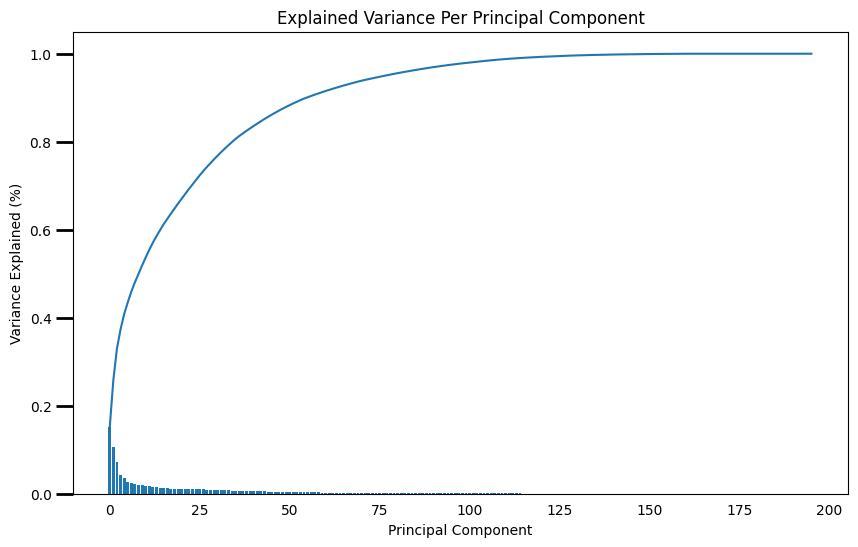

In [60]:
# Investigate the variance accounted for by each principal component.

# Scree Plot
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 77
pca = PCA(n_components=n_components)
pca.fit(df_scaled)

PCA(n_components=77)

In [62]:
# Transform the data by applying PCA transformation to it
df_pca = pca.transform(df_scaled)
df_pca.shape

(623209, 77)

#### Create transformation function

Summarize all transformation steps in a function

In [63]:
def transform_data(df, n_components = 77):
    """
    Apply PCA to the data
    :returns: the transformed data frame and the PCA model
    """
    # Create PCA transformer
    pca = PCA(n_components=n_components)

    # Apply PCA to the data while selecting for number of components to retain.
    pca.fit(df)
    
    # Transform the data by applying PCA transformation to it
    df = pca.transform(df)
    
    return df, pca

df_pca, pca = transform_data(df_scaled.copy())

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

In this section I applied the Principal Component Analysis algorithm to the cleand and scaled data frame. The resulting principal components are shown in a scree plot. The bars in the scree plot describe how much variance each PC can describe, while the curve describes the cummulated variance that the PCs can describe. In the scree plot we can see that the cumulative variance first increases a lot and than converges. The last 75 PCs do not seem to contribute anything to the variance.

We can see that we only need the first 77 PCs to describe 95% of the variance of our features. Compared to the 196 feature of the original data frame this is a significant reduction. We also need 114 PCs to nearly explain the total variance of our data frame.

I decided to reduce the data frame to 77 PCs to keep 95% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [64]:
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions
    
	return pd.concat([variance_ratios, components], axis = 1)

def get_feature_weight_of_pca(df, pca, pca_index):
    return pca_results(df, pca).iloc[pca_index, :].sort_values(ascending=False)

LP_STATUS_GROB_1.0        0.2004
PLZ8_ANTG3                0.1941
PLZ8_ANTG4                0.1888
PLZ8_BAUMAX               0.1855
CAMEO_INTL_2015_WEALTH    0.1802
KBA05_GBZ                -0.1892
PLZ8_ANTG1               -0.1952
KBA05_ANTG1              -0.1989
FINANZ_MINIMALIST        -0.2055
MOBI_REGIO               -0.2126
Name: Dimension 1, dtype: float64

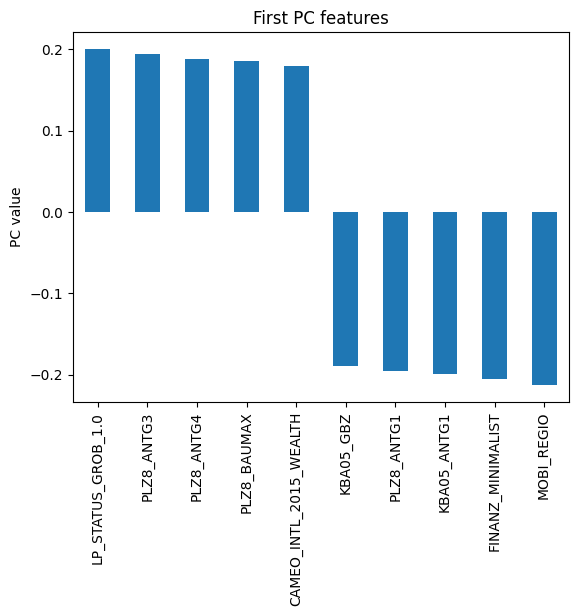

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
first_pca_weights = get_feature_weight_of_pca(df_cleaned, pca, 0)
first_pca_weights

# Plot the top 5 and the bottom 5 principal components
first_pca_weights[[0,1,2,3,4,-5,-4,-3,-2,-1]].plot.bar(title="First PC features", ylabel="PC value")
first_pca_weights[[0,1,2,3,4,-5,-4,-3,-2,-1]]

ALTERSKATEGORIE_GROB            0.2444
FINANZ_VORSORGER                0.2152
SEMIO_ERL                       0.2046
SEMIO_LUST                      0.1692
RETOURTYP_BK_S                  0.1650
FINANZ_UNAUFFAELLIGER          -0.2183
SEMIO_PFLICHT                  -0.2238
FINANZ_SPARER                  -0.2242
SEMIO_REL                      -0.2389
PRAEGENDE_JUGENDJAHRE_DECADE   -0.2398
Name: Dimension 2, dtype: float64

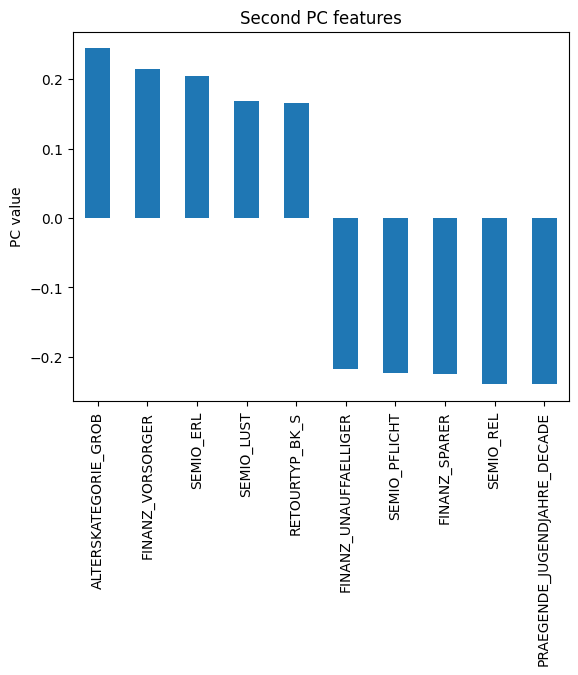

In [66]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_pca_weights = get_feature_weight_of_pca(df_cleaned, pca, 1)
second_pca_weights

# Plot the top 5 and the bottom 5 principal components
second_pca_weights[[0,1,2,3,4,-5,-4,-3,-2,-1]].plot.bar(title="Second PC features", ylabel="PC value")
second_pca_weights[[0,1,2,3,4,-5,-4,-3,-2,-1]]

SEMIO_VERT           0.3431
SEMIO_FAM            0.2679
SEMIO_SOZ            0.2674
SEMIO_KULT           0.2534
FINANZ_MINIMALIST    0.1450
SEMIO_ERL           -0.1946
SEMIO_KRIT          -0.2717
SEMIO_DOM           -0.3073
SEMIO_KAEM          -0.3371
ANREDE_KZ           -0.3666
Name: Dimension 3, dtype: float64

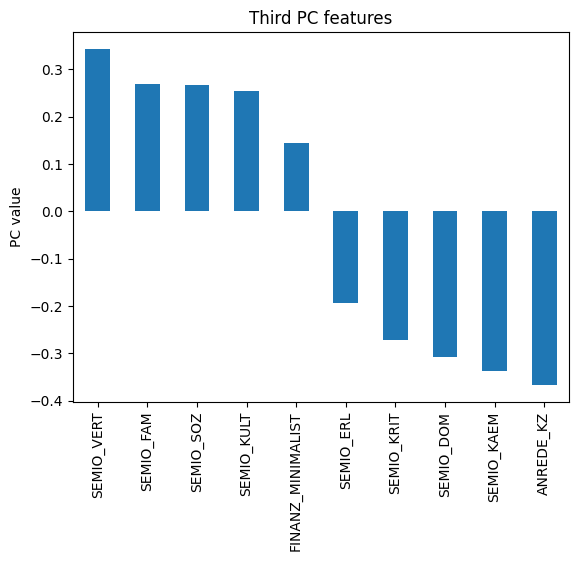

In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third_pca_weights = get_feature_weight_of_pca(df_cleaned, pca, 2)
third_pca_weights

# Plot the top 5 and the bottom 5 principal components
third_pca_weights[[0,1,2,3,4,-5,-4,-3,-2,-1]].plot.bar(title="Third PC features", ylabel="PC value")
third_pca_weights[[0,1,2,3,4,-5,-4,-3,-2,-1]]

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

In this section we inspected the principal components and the features by which they are influenced the most.

The columns `MOBI_REGIO`, `FINANZ_MINIMALIST` and `LP_STATUS_GROB_1.0` have the most impact on the first principal component. These features describe the movement pattern, the financial topology and the social status of the persons. It seems logical that these features influence the purchasing behaviour.

The second principal component is mostly influenced by the columns `ALTERSKATEGORIE_GROB`, `PRAEGENDE_JUGENDJAHRE_DECADE` and `SEMIO_REL`. These columns describe the estimated age of the person, the decade the person has grown up and the personality typology.

The columns that most influence the thirst principal component are `ANREDE_KZ`, `SEMIO_VERT` and `SEMIO_KAEM`. These features describe the gender and again the personality typology.

In summarization we can see that financial aspects, the personality of a person, the age, gender and the socialization seem to be good features to create good segments of customers. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [68]:
max_k = 30
cluster_distances = []

# Iterate over values for parameter k (numbers of clusters)
for index, k in enumerate(range(2, max_k + 1)):
    print(f"Calculating scores for {k} clusters ...")
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(df_pca)
    # compute the average within-cluster distances.
    cluster_distances.append(np.abs(kmeans.score(df_pca)))

Calculating scores for 2 clusters ...
Calculating scores for 3 clusters ...
Calculating scores for 4 clusters ...
Calculating scores for 5 clusters ...
Calculating scores for 6 clusters ...
Calculating scores for 7 clusters ...
Calculating scores for 8 clusters ...
Calculating scores for 9 clusters ...
Calculating scores for 10 clusters ...
Calculating scores for 11 clusters ...
Calculating scores for 12 clusters ...
Calculating scores for 13 clusters ...
Calculating scores for 14 clusters ...
Calculating scores for 15 clusters ...
Calculating scores for 16 clusters ...
Calculating scores for 17 clusters ...
Calculating scores for 18 clusters ...
Calculating scores for 19 clusters ...
Calculating scores for 20 clusters ...
Calculating scores for 21 clusters ...
Calculating scores for 22 clusters ...
Calculating scores for 23 clusters ...
Calculating scores for 24 clusters ...
Calculating scores for 25 clusters ...
Calculating scores for 26 clusters ...
Calculating scores for 27 cluster

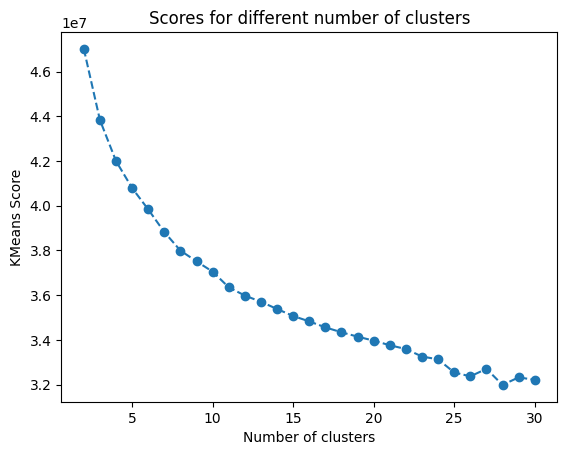

In [69]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(2, max_k+1), cluster_distances, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('KMeans Score')
plt.title("Scores for different number of clusters")
plt.show()

In [70]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_optimal = 16
kmeans = KMeans(n_clusters=k_optimal, random_state=0, n_init='auto').fit(df_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

First we try out several numbers of clusters (k) and calculate the average cluster distance for each of these values. We can see that there is no clear ellbow in the plot, so we have to choose another method to determine the ideal number of clusters. We can see that the curve converges until the number of 16 clusters. Then there is a small kink. This is why I chose 16 as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [71]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

In [72]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)
customers_cleaned = customers.copy()
customers, scaler_customers, scaled_features_customers = scale_data(customers)
customers, pca_customers = transform_data(customers)
customers_pred = kmeans.predict(customers)

In [73]:
azdias = clean_data(azdias)
azdias_cleaned = azdias.copy()
azdias, scaler_azdias, scaled_features_azdias = scale_data(azdias)
azdias, pca_azdias = transform_data(azdias)
azdias_pred = kmeans.predict(azdias)

In [74]:
# Add the cluster index to the customers data frame
customers_cleaned['pred'] = customers_pred
customers_cleaned['is_customer'] = 'yes'

azdias_cleaned['pred'] = azdias_pred
azdias_cleaned['is_customer'] = 'no'

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [75]:
# Count the occurences of distinct values in both predictions and then
# coompute the relative difference of the clusters between both data frames
azdias_values, azdias_counts = np.unique(azdias_pred, return_counts=True)
customers_values, customers_counts = np.unique(customers_pred, return_counts=True)
df_diff = pd.DataFrame({'values': azdias_values, 'diff': (customers_counts / customers_pred.shape[0])*100 - (azdias_counts / azdias_pred.shape[0])*100 })
df_diff

,values,diff
0,0,-0.631501
1,1,-1.284905
2,2,-0.968915
3,3,-0.899083
4,4,-2.544030
5,5,-0.783245
6,6,4.639612
7,7,5.854659
8,8,-0.370674
9,9,0.173134


Text(0.5, 1.0, 'Relative Difference in %')

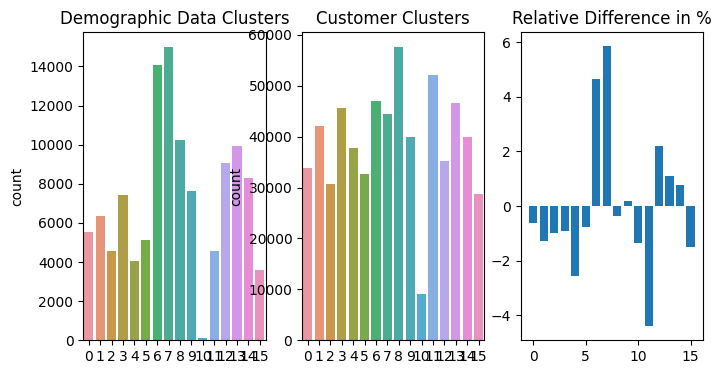

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fix, ax = plt.subplots(1, 3, figsize=(8,4))
sns.countplot(x=customers_pred, ax=ax[0])
ax[0].set_title('Demographic Data Clusters')
sns.countplot(x=azdias_pred, ax=ax[1])
ax[1].set_title('Customer Clusters')
ax[2].bar(df_diff['values'], height=df_diff['diff'])
ax[2].set_title('Relative Difference in %')

<BarContainer object of 6 artists>

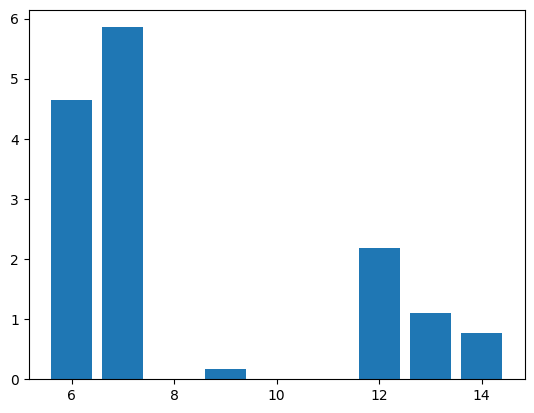

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
mask = df_diff['diff'] > 0.0
plt.bar(df_diff[mask]['values'], df_diff[mask]['diff'])

The clusters 0,1,4,9,11,14 and 15 are overrepresented in the customer data.

In [78]:
overrepresented_clusters = [0,1,4,9,11,14,15]

<BarContainer object of 10 artists>

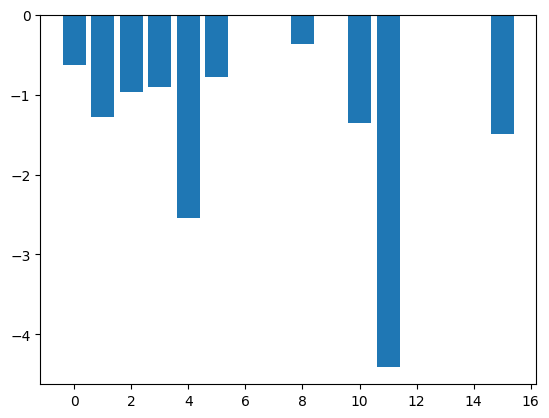

In [79]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

mask = df_diff['diff'] < 0.0
plt.bar(df_diff[mask]['values'], df_diff[mask]['diff'])

The clusters 2,3,5,6,7,8,10,12 and 13 are underrepresented in the customer data.

In [80]:
underrepresented_clusters = [2,3,5,6,7,8,10,12,13]

#### Inspect the important features of the over- and underrepresented clusters

In [81]:
# The important features found by PCA
important_features = [
    "MOBI_REGIO", "FINANZ_MINIMALIST", "LP_STATUS_GROB_1.0",
    "ALTERSKATEGORIE_GROB", "PRAEGENDE_JUGENDJAHRE_DECADE", "SEMIO_REL",
    "ANREDE_KZ", "SEMIO_VERT", "SEMIO_KAEM"
]

mask_overrepresented = np.isin(customers_cleaned['pred'], overrepresented_clusters)
mask_underrepresented = np.isin(customers_cleaned['pred'], underrepresented_clusters)

customers_cleaned['overrepresented'] = mask_overrepresented

#### Distribution of important features in the underrepresented clusters

The following violin plots will compare the distribution of the most important features found by PCA in the overrepresented clusters and the underrepresented ones.

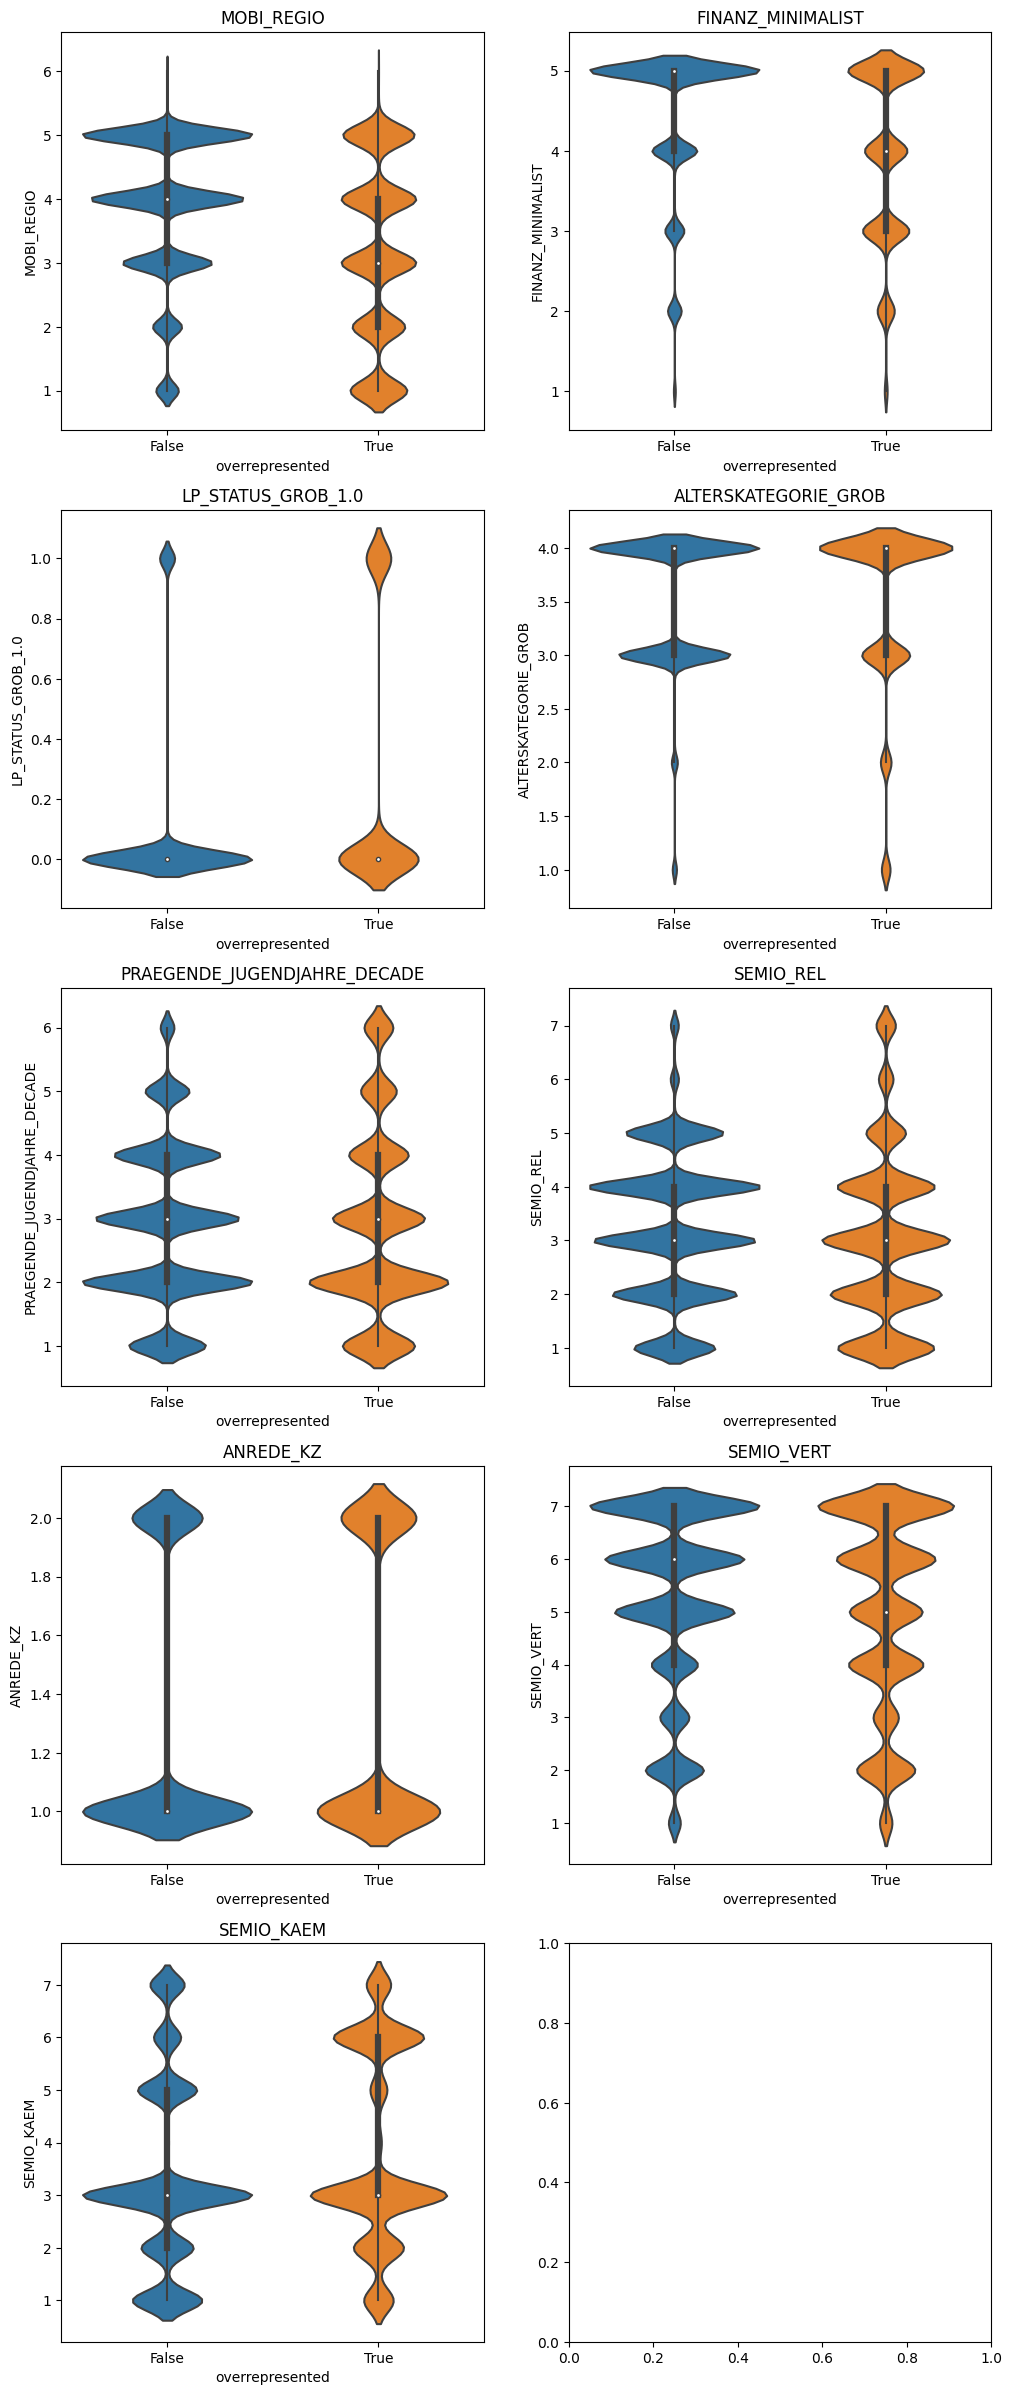

In [82]:
fix, ax = plt.subplots(5, 2, figsize=(12,30))

for i in range(9):
    ax[i // 2][i % 2].set_title(important_features[i])
    sns.violinplot(
        data=customers_cleaned,
        x='overrepresented',
        y=important_features[i],
        ax=ax[i // 2][i % 2]
    )

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the violin plot we can make the following conclusions:

`MOBI_REGIO`:
This plot shows that people with high or very high movement patterns are overrerpesented in the customer data.

`FINANZ_MINIMALIST`
The people that are financial minimalists are highly underrepresented in the customer data set. This means that the income of the customers is high.

`LP_STATUS_GROB_1.0`
We can see that people that fall into the first category of the feature LP_STATUS_GROB, which represents low-income earners, are slightly underrepresented. People that are not low-income earners are overrepresented in the customer data set.

`ALTERSKATEGORIE_GROB`
People in the customers data that are older than 60 years are overrepresented compared to the general population. Also young people are highly underrepresented.

`PRAEGENDE_JUGENDJAHRE_DECADE`
This feature shows that people that grew up in the 50s and 60s are overrepresented in the customers data set. People that grew up in the 80s and the 90s are underrepresented in the customer data set. This is consistent with the observations from column ALTERSKATEGORIE_GROB

`SEMIO_REL`
People that have a very low affinity to the personality topology SEMIO_REL are highly overrepresented in the customers data set, while people with a high affinity to this category are slightly underrepresented

`ANREDE_KZ`
Men are highly overrepresented in the customer data set while women are underrepresented.

`SEMIO_VERT`
People that have a low affinity to the personality topology SEMIO_VERT are highly overrepresented in the customers data set, while people with a high affinity to this category are slightly underrepresented

`SEMIO_KAEM`
People that have a low affinity to the personality topology SEMIO_KAEM are highly underrepresented in the customers data set, while people with a high affinity to this category are overrepresented

***Summary***:
All in all it seems that men who are 60 years old or older and have a high income are overrepresented in the customer data set. The campaign should put its focus on that group.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.